In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Hudson Strait')

maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

In [5]:
Sref = 35.0

In [6]:
grid = ecco.get_llc_grid(main)

In [7]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [8]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

In [9]:
sec_FWtrsp_x = (ADVx_FW * maskW).sum(dim=['tile'])
sec_FWtrsp_y = (ADVy_FW * maskS).sum(dim=['tile'])

In [10]:
Sv = 1e-6
sec_x = sec_FWtrsp_x.sum('k').compute()*Sv
sec_y = sec_FWtrsp_y.sum('k').compute()*Sv

In [11]:
j = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().j.values
    
i_g = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().i_g.values
    
j_g = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().j_g.values
    
i = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().i.values

In [12]:
sec_x_mean = np.array([])

In [13]:
sec_x_mean

array([], dtype=float64)

In [14]:
if j.size == 0:
    sec_x_mean = np.array([])
    sec_x_anom_mean = np.array([])
else:
    sec_x_mean = sec_x.mean('time').values[j,i_g]*1e3
    sec_x_anom_mean = sec_x_anom.mean('time').values[j,i_g]*1e3

In [22]:
sec_x.mean('time')

<xarray.DataArray (j: 90, i_g: 90)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

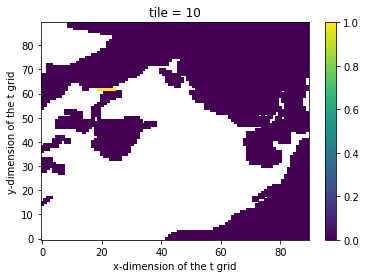

In [5]:
maskC[10].where(main.hFacC[0,10].values==1).plot()

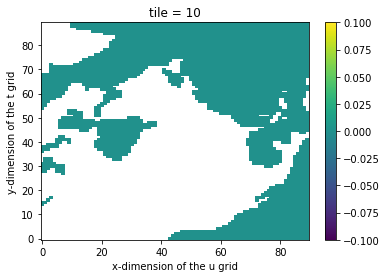

In [6]:
maskW[10].where(main.hFacW[0,10].values==1).plot()

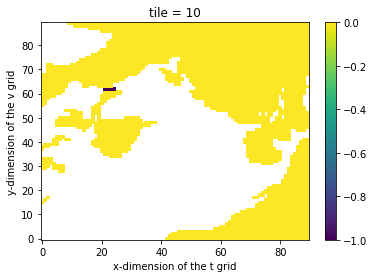

In [7]:
maskS[10].where(main.hFacS[0,10].values==1).plot()

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [18]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [19]:
# Get area for strait
dyA_HS = dyA*maskW
dxA_HS = dxA*maskS*-1

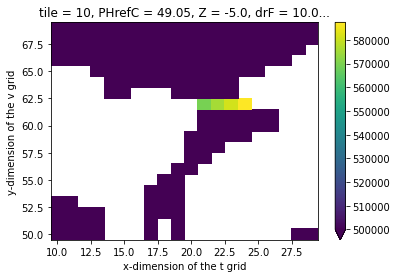

In [20]:
dxA_HS[10,:,:,0].where(main.hFacS[0,10].values==1)[50:70,10:30].plot(vmin=5e5)

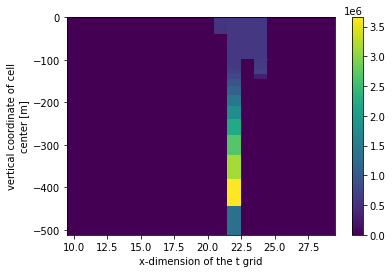

In [11]:
dxA_HS.sum(dim=['j_g','tile'])[10:30,:23].T.swap_dims({'k':'Z'}).plot()

In [21]:
sec_area_x = dyA_HS.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_HS.sum(dim=['i','j_g','tile'])

In [22]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 43.0 km^2


### Volume flux

In [23]:
u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

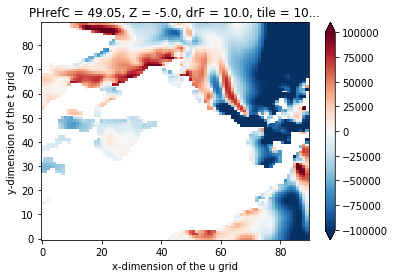

In [24]:
u_transport[:,0,10].mean('time').where(main.hFacW[0,10].values==1).plot(vmin=-1e5)

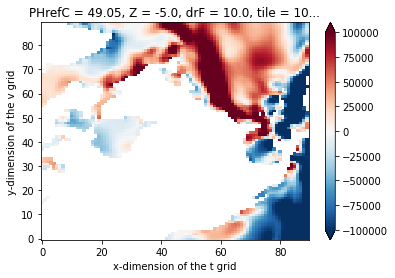

In [25]:
v_transport[:,0,10].mean('time').where(main.hFacS[0,10].values==1).plot(vmin=-1e5)

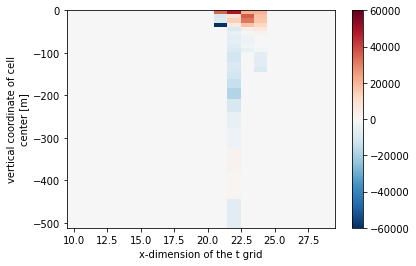

In [26]:
(v_transport * maskS*-1).sum(dim=['j_g','tile']).mean('time')[:23,10:30].swap_dims({'k':'Z'}).plot()

In [27]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
#sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])
sec_trsp_y = (v_transport * maskS*-1).sum(dim=['i','j_g','tile'])

In [28]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_trsp = sec_trsp.sel(time=slice('1993-01-01','2015-12-31'))

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,2),'±',np.round(2*sec_trsp.std('time').values,2),'Sv')

Vol. flux (1992-2015): 0.03 ± 0.1 Sv


### Calculate freshwater fluxes

In [29]:
# Reference salinity
Sref = 34.8
#Sref = 35.0

In [30]:
grid = ecco.get_llc_grid(main)

In [31]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [32]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

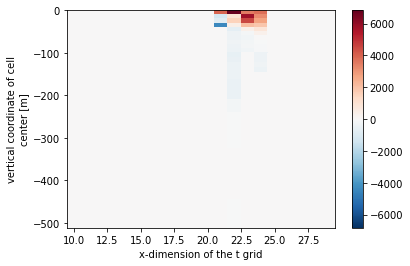

In [26]:
(ADVy_FW * maskS*-1).sum(dim=['j_g','tile']).mean('time')[:23,10:30].swap_dims({'k':'Z'}).plot()

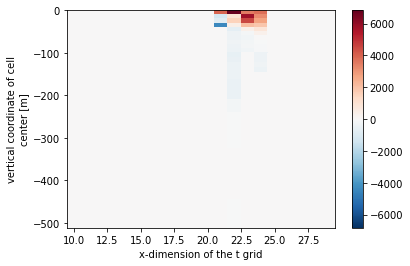

In [27]:
(ADVy_FW.where(SALT_at_v.values<=Sref)*maskS*-1).sum(dim=['j_g','tile']).mean('time')[:23,10:30]\
            .swap_dims({'k':'Z'}).plot()

In [33]:
# Full-depth integration
sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW * maskS*-1).sum(dim=['i','j_g','tile'])

# Integration from isohaline
#sec_trsp_x = (ADVx_FW.where(SALT_at_u.values<=Sref) * maskW).sum(dim=['i_g','j','tile'])
#sec_trsp_y = (ADVy_FW.where(SALT_at_v.values<=Sref) * maskS*-1).sum(dim=['i','j_g','tile'])

In [34]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_FWtrsp = sec_FWtrsp.sel(time=slice('1993-01-01','2015-12-31'))

print('FW flux (Sref =',Sref, '/ full-depth integration','/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')
#print('FW flux (Sref =',Sref, '/ integration from isohaline','/ 1992-2015):', 
#      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 34.8 / full-depth integration / 1992-2015): 28.5 ± 22.5 mSv


FW flux (Sref = 34.8 / integration from isohaline / 1992-2015): 28.5 ± 22.5 mSv


FW flux (Sref = 35.0 / full-depth integration / 1992-2015): 25.4 ± 24.5 mSv


### Sea ice flux

In [33]:
#Sref = 35.0
Sref = 34.8
Sice = 4.0
rho_w = 1003
rho_ice = 900

ice_to_fw = (1-Sice/Sref)*(rho_ice/rho_w)

In [34]:
# Sea ice freshwater fluxes (m^3/s)
SIu_transport = main['SIuheff'] * main['dyG'] * ice_to_fw
SIv_transport = main['SIvheff'] * main['dxG'] * ice_to_fw

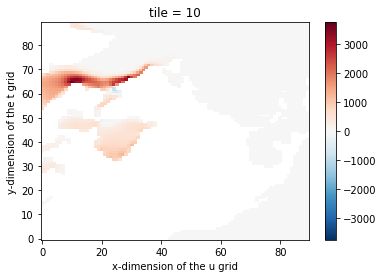

In [35]:
SIu_transport.mean('time')[10].where(main.hFacW[0,10].values==1).plot()

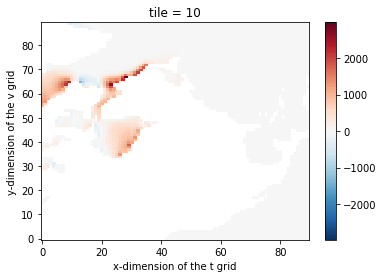

In [36]:
SIv_transport.mean('time')[10].where(main.hFacS[0,10].values==1).plot()

In [37]:
# Sea ice freshwater fluxes through strait (m^3/s)
sec_trsp_x = (SIu_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (SIv_transport * maskS*-1).sum(dim=['i','j_g','tile'])

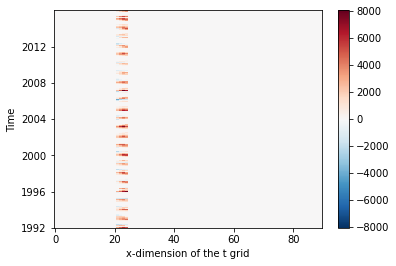

In [38]:
(SIv_transport * maskS*-1).sum(dim=['j_g','tile']).plot()

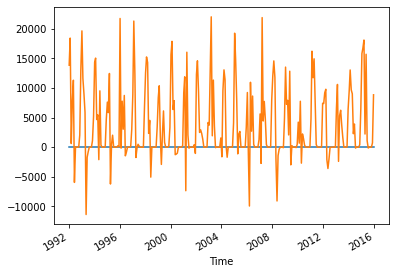

In [39]:
sec_trsp_x.plot()
sec_trsp_y.plot()

In [40]:
# Sea ice freshwater transport (Sv)
sec_SItrsp = (sec_trsp_x + sec_trsp_y).compute()*Sv

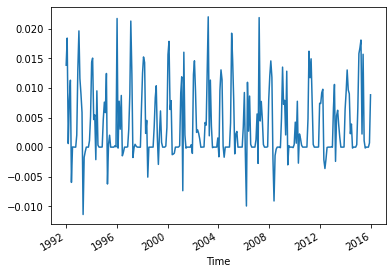

In [41]:
sec_SItrsp.plot()

In [42]:
print('Sea ice FW flux (Sref =',Sref, '/ Sice =',Sice,'/ 1992-2015):', 
      np.round(sec_SItrsp.mean('time').values*1e3,1),'±',np.round(2*sec_SItrsp.std('time').values*1e3,1),'mSv')

Sea ice FW flux (Sref = 34.8 / Sice = 4.0 / 1992-2015): 3.5 ± 11.9 mSv


In [44]:
import datetime

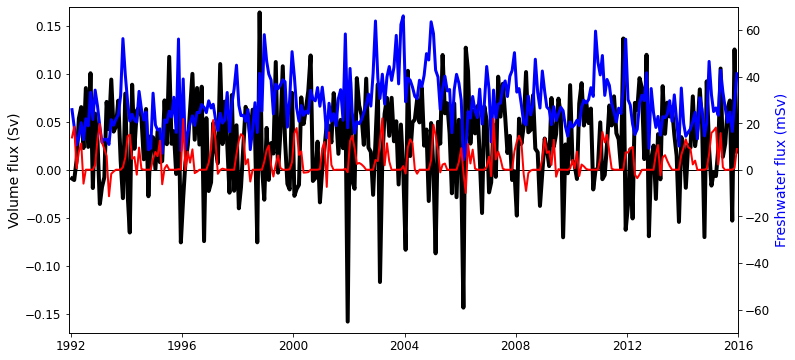

In [46]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(sec_trsp.time, sec_trsp, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax1.set_ylim([-0.17,0.17])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(sec_FWtrsp.time, sec_FWtrsp*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(sec_SItrsp.time, sec_SItrsp*1e3, lw=2, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax2.set_ylim([-70,70])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='b', fontsize=14)

plt.show()